### Load libraries and Stable Diffusion model

In [1]:
!pip install torch diffusers transformers accelerate scipy safetensors matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.8 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import userdata
from huggingface_hub import login
from diffusers import LMSDiscreteScheduler
login(userdata.get('HF_TOKEN'))
from importlib import reload

Clone github repo for utils functions

#### Class for sampling attention layers

In [3]:
!git clone https://{userdata.get('GITHUB_TOKEN')}@github.com/aadeoye911/CompASS.git
%cd CompASS
import compass_pipeline as comp

Cloning into 'CompASS'...
remote: Enumerating objects: 961, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 961 (delta 52), reused 58 (delta 28), pack-reused 879 (from 2)
Receiving objects: 100% (961/961), 8.71 MiB | 31.86 MiB/s, done.
Resolving deltas: 100% (607/607), done.
/content/CompASS


In [34]:
%cd CompASS
!git fetch --all
!git reset --hard origin/main  # or origin/branch-name
!git pull origin main --force
reload(comp)

[Errno 2] No such file or directory: 'CompASS'
/content/CompASS
Fetching origin
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 282 bytes | 282.00 KiB/s, done.
From https://github.com/aadeoye911/CompASS
   91b96d8..9283764  main       -> origin/main
HEAD is now at 9283764 Centoird guidance
From https://github.com/aadeoye911/CompASS
 * branch            main       -> FETCH_HEAD
Already up to date.


<module 'compass_pipeline' from '/content/CompASS/compass_pipeline.py'>

In [ ]:
import gc
del pipe
gc.collect()
torch.cuda.empty_cache()

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id="stable-diffusion-v1-5/stable-diffusion-v1-5"
pipe = comp.CompASSPipeline.from_pretrained(model_id)
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
print(pipe.scheduler.sigmas[0])

tensor(14.6146)


In [6]:
seed = torch.randint(0, 2**32 - 1, (1,)).item()
prompts = ["A black dog lying next to a tree", "A couple strolling on a beach at sunset", "A futuristic city at night", "A man dragging a suitcase in an airport", "A woman looking at her reflection in a bathroom mirror"]

In [12]:
centroid_list = []
image_list = []
control_list = []

In [23]:
control_list = control_list[:-1]

In [21]:
print(len(image_list))

4


In [ ]:
prompts = ["A woman looking at her reflection in a bathroom mirror"] * 6

seed = torch.randint(0, 2**32 - 1, (1,)).item()
generator = torch.Generator(device=pipe.device).manual_seed(seed)
for prompt in prompts:
    image = pipe(prompt, 512, 512, generator=generator, eta=0.4, run_compass=True, guidance_scale=7.5)[0]
    image_list.append(image[0])
    control = pipe(prompt, 512, 512, generator=generator, run_compass=False, guidance_scale=7.5)[0]
    control_list.append(control[0])



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [31]:
import matplotlib.pyplot as plt

def plot_third_lines(ax, color='red', style='--', width=1):
    ax.axvline(x=ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) / 3, color=color, linestyle=style, linewidth=width)
    ax.axhline(y=ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) / 3, color=color, linestyle=style, linewidth=width)
    ax.axvline(x=ax.get_xlim()[0] + 2 * (ax.get_xlim()[1] - ax.get_xlim()[0]) / 3, color=color, linestyle=style, linewidth=width)
    ax.axhline(y=ax.get_ylim()[0] + 2 * (ax.get_ylim()[1] - ax.get_ylim()[0]) / 3, color=color, linestyle=style, linewidth=width)

In [32]:
def plot_image_rows(list1, list2, row1_label="Control", row2_label="RoT, ε=0.4"):
    num_images = min(len(list1), len(list2))
    fig, axs = plt.subplots(2, num_images, figsize=(3*num_images, 6))
    for i in range(num_images):
        # Row 1
        axs[0, i].imshow(list1[i])
        axs[0, i].axis("off")
        if i == 0:
            axs[0, i].set_ylabel(row1_label, fontsize=14)
        plot_third_lines(axs[0, i], width=2)

        # Row 2
        axs[1, i].imshow(list2[i])
        axs[1, i].axis("off")
        if i == 0:
            axs[1, i].set_ylabel(row2_label, fontsize=14)
        plot_third_lines(axs[1, i], width=2)


    plt.tight_layout()
    plt.show()

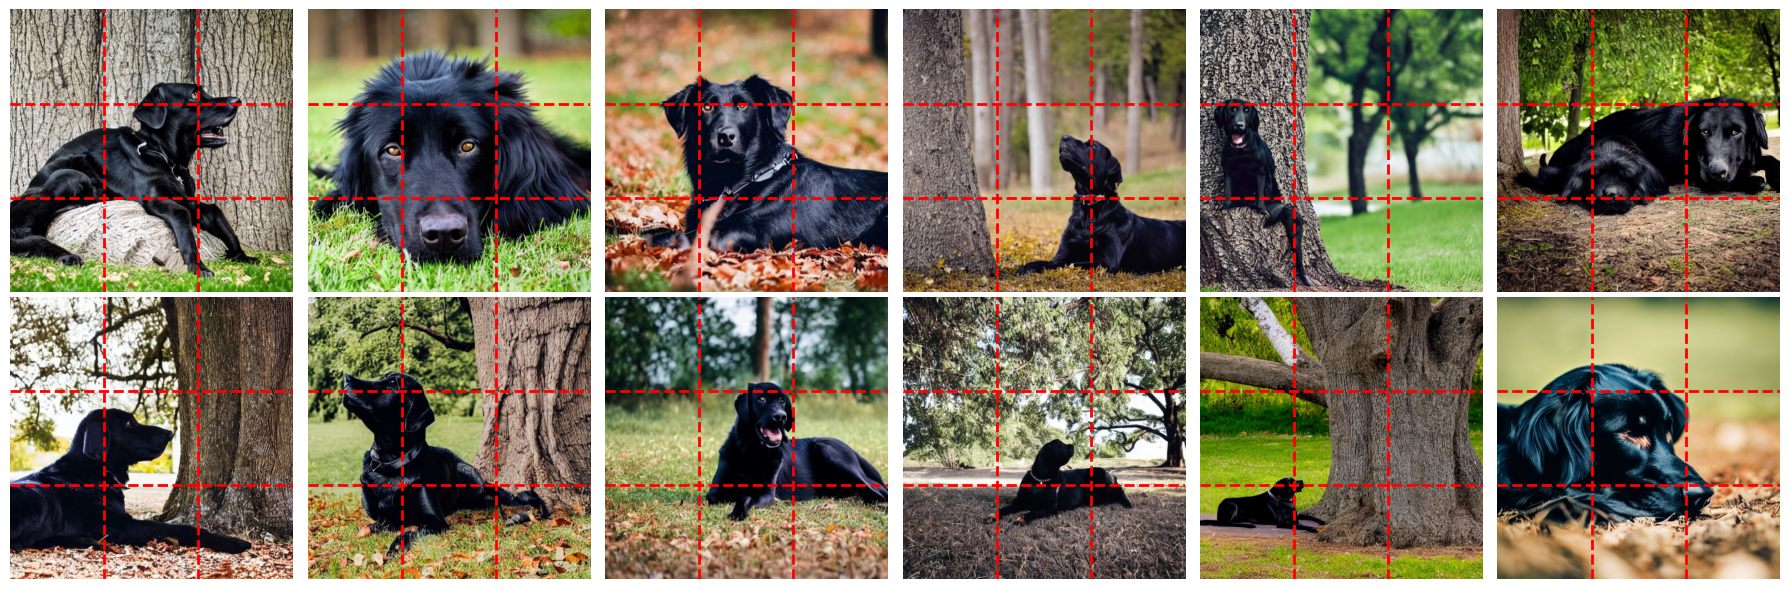

In [33]:
plot_image_rows(control_list, image_list)

In [ ]:
import matplotlib.pyplot as plt

def view_image(images, titles, cols=5, figsize=(23, 3)):
    """Display a PIL image using matplotlib."""
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if titles and i < len(titles):
            plt.title(titles[i])

    plt.tight_layout()
    plt.show()

view_image(image_list, prompts)

In [ ]:
view_image(image_list, prompts)

#### Class for visualizing